In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
!ls drive

ls: cannot access 'drive': No such file or directory


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [18]:
%cd drive/dog-breed-identification

[Errno 2] No such file or directory: 'drive/dog-breed-identification'
/content/drive/dog-breed-identification


In [19]:
!pip3 install torchvision

In [17]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 


In [0]:
import math
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
from torch.optim import lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.utils import make_grid

%matplotlib inline

In [23]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
#import PIL.image



    100% |████████████████████████████████| 5.6MB 6.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 5.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


In [0]:
path = ''
batch_size =8
epochs = 5
num_classes = 120

In [0]:
import pandas as pd
labels = pd.read_csv(path + 'labels.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [67]:
selected_labels = labels
selected_labels['class'] = pd.Categorical(labels['breed'].astype(str)).codes
selected_labels[:5]


,id,breed,class
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [0]:
selected_labels['class'] = selected_labels['class'].astype(np.int64)


In [0]:
from sklearn.model_selection import train_test_split
train_labels, valid_labels = train_test_split(selected_labels, test_size=0.3,shuffle=True)


In [0]:
class DogsDataset(Dataset):
    def __init__(self, root_dir, labels, transform, output_class=True):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.output_class = output_class
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = self.labels.iloc[idx]
        path = '{}/{}.jpg'.format(self.root_dir, item['id'])
        #print(item['id'])
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        if not self.output_class:
            return image
        #print(image,item['class'])
        
        return image, item['class']

In [0]:
def train(model, train, valid, optimizer, criterion, epochs=1, scheduler=None):
    for epoch in range(epochs):
        print('Epoch ', epoch + 1, '/', epochs)
        
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        if scheduler:
            scheduler.step()
            
        model.train()
        for i, (input, target) in enumerate(train):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)

            optimizer.zero_grad()

            # compute output
            output = model(input_var)
            #print(output)
            #print(target_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

            print('\r', 'Batch', i, 'Loss', loss.data[0], end='')
            
        train_loss = running_loss / running_batches
        train_acc = running_corrects / len(train.dataset.labels)
        print('\r', "Train Loss", train_loss, "Train Accuracy", train_acc)
            
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        model.eval()
        for i, (input, target) in enumerate(valid):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

            output = model(input_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

        valid_loss = running_loss / running_batches
        valid_acc = running_corrects / len(valid.dataset.labels)
        #print()
        print('\r', "Val Loss", valid_loss, "Val Accuracy", valid_acc)

In [0]:
"""def get_mean_and_std(dataloader):
    '''Compute the mean and std value of dataset.'''
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std"""

mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]

In [0]:
def imshow(inp, title=None):
    npimg = inp.numpy()
    npimg = np.transpose(npimg, (1,2,0))
    mean = np.array(mean_rgb)
    std = np.array(std_rgb)
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg, interpolation='nearest')


In [0]:
normalize = transforms.Normalize(mean=mean_rgb,
                                 std=std_rgb)

train_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [0]:
train_dataset = DogsDataset(path + 'train', train_labels, train_trans)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    DogsDataset(path + 'train', valid_labels, val_trans),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    DogsDataset(path + 'test', sample_submission, val_trans, output_class=False),
    batch_size=batch_size
)

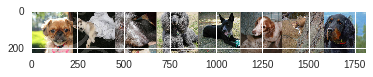

In [62]:
inputs, derp = next(iter(train_loader))
out = make_grid(inputs)
imshow(out)

In [0]:
model = models.densenet169(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.classifier.parameters()) #torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=5 , scheduler=scheduler)

Epoch  1 / 5
 Batch 24 Loss 6.048348903656006

In [0]:
torch.save(model.state_dict(), path + 'model_weights')

In [0]:
model.load_state_dict(torch.load(path + 'model_weights'))

In [0]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=4, scheduler=scheduler)


Epoch  1 / 4
 Train Loss 0.14428360719572414 Train Accuracy 0.9699810606060606


In [0]:
torch.save(model.state_dict(), path + 'weights1a.torch')


In [0]:
model.load_state_dict(torch.load(path + 'weights1a.torch'))
model.eval()
results = []

for i, input in enumerate(test_loader):
    input = input.cuda()
    input_var = torch.autograd.Variable(input, volatile=True)
    output = model(input_var)
    results.append(F.softmax(output, dim=1).cpu().data.numpy())
    print('\r', 'Batch', i, end='')
    
results = np.concatenate(results)

In [0]:
ids = sample_submission['id'].values
sdf = pd.DataFrame(ids, columns=['id'])

for index, breed in enumerate(all_classes):
    if index < num_classes:
        sdf[breed] = np.clip(results[:,index], 0.00, 1.)
    else:
        sdf[breed] = 0.01
    
sdf = sdf.sort_values('id').reset_index(drop=True)
sdf = sdf[['id'] + sorted(all_classes)]
print(sdf)
sdf.to_csv('pred2.csv', index=None)

FileLink('pred.csv')